## Disease-associated genes clustering

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy
import pertpy
import yaml

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

In [6]:
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [7]:
# Load target clustering data
clustering_data = pd.read_parquet('../../metadata/clustering_nde30ntotals75.parquet')
print("Shape:", clustering_data.shape)
print("Columns:", clustering_data.columns.tolist())
clustering_data.head()

Shape: (96, 23)
Columns: ['cluster', 'complex_corum', 'overlap_genes_corum', 'overlap_fraction_corum', 'raw_p_value_corum', 'complex_size_corum', 'complex_stringdb', 'overlap_genes_stringdb', 'overlap_fraction_stringdb', 'raw_p_value_stringdb', 'complex_size_stringdb', 'complex_kegg', 'overlap_genes_kegg', 'overlap_fraction_kegg', 'raw_p_value_kegg', 'complex_size_kegg', 'complex_reactome', 'overlap_genes_reactome', 'overlap_fraction_reactome', 'raw_p_value_reactome', 'complex_size_reactome', 'cluster_size', 'cluster_member']


,cluster,complex_corum,overlap_genes_corum,overlap_fraction_corum,raw_p_value_corum,complex_size_corum,complex_stringdb,overlap_genes_stringdb,overlap_fraction_stringdb,raw_p_value_stringdb,...,overlap_fraction_kegg,raw_p_value_kegg,complex_size_kegg,complex_reactome,overlap_genes_reactome,overlap_fraction_reactome,raw_p_value_reactome,complex_size_reactome,cluster_size,cluster_member
0,0,Integrator complex,[INTS10],0.125000,4.028837e-02,12,CL:35457,"[INTS13, INTS14, INTS10]",0.375000,2.603933e-07,...,0.000000,1.000000,44,REACTOME_RNA_POLYMERASE_II_TRANSCRIBES_SNRNA_G...,"[INTS13, INTS14, INTS10]",0.375000,1.964599e-03,81,8,"[INTS13, ARID5B, FGFR1OP2, C7orf26, INTS10, EB..."
1,3,"Elongator complex (ELP1, ELP2, ELP3, ELP4, ELP...","[ELP2, ELP5, ELP1, ELP4, ELP3]",0.384615,1.311407e-11,6,CL:7614,"[URM1, MOCS3, ELP5, ELP2, ELP1, CTU1, KTI12, C...",0.769231,1.391330e-23,...,0.076923,0.227655,46,REACTOME_HATS_ACETYLATE_HISTONES,"[ELP5, ELP2, ELP1, ELP4, ELP3]",0.384615,6.592078e-04,142,13,"[URM1, MOCS3, DPM1, ELP5, ELP2, SLC39A6, ELP1,..."
2,4,BCL6-HDAC4 complex,[],0.000000,1.000000e+00,2,CL:7638,"[DPH6, DPH1, DPH5]",0.500000,9.311703e-08,...,0.000000,1.000000,44,REACTOME_SYNTHESIS_OF_DIPHTHAMIDE_EEF2,"[DPH5, DPH1, DPH6, DNAJC24]",0.666667,8.346291e-10,8,6,"[DPH6, TTC4, DPH1, TPT1, DPH5, DNAJC24]"
3,5,BCL6-HDAC4 complex,[],0.000000,1.000000e+00,2,CL:7638,"[DPH1, DPH2, DPH5]",0.500000,9.311703e-08,...,0.000000,1.000000,44,REACTOME_SYNTHESIS_OF_DIPHTHAMIDE_EEF2,"[DPH5, DPH1, DPH2, DNAJC24]",0.666667,8.346291e-10,8,6,"[TTC4, DPH1, TPT1, DPH2, DPH5, DNAJC24]"
4,6,BCL6-HDAC4 complex,[],0.000000,1.000000e+00,2,CL:7638,"[DPH6, DPH1, DPH2, DPH5]",0.666667,5.973890e-11,...,0.000000,1.000000,44,REACTOME_SYNTHESIS_OF_DIPHTHAMIDE_EEF2,"[DPH6, DPH1, DPH2, DPH5, DNAJC24]",0.833333,5.716392e-13,8,6,"[DPH6, DPH1, TPT1, DPH2, DPH5, DNAJC24]"


In [8]:
clust_adata = sc.read_h5ad('../../results/nde30ntotal75_clustering.h5ad', backed=True)

In [9]:
clust_adata.obs['clustering'] = clust_adata.obs['hdbscan'].copy()

In [10]:
clust_adata.obs.head()

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,leiden,hierarchical,hdbscan,clustering
ENSG00000104368_Stim8hr,PLAT,Stim8hr,ENSG00000104368,0,411.0,2,45,76,76
ENSG00000128607_Stim8hr,KLHDC10,Stim8hr,ENSG00000128607,0,1257.0,19,95,77,77
ENSG00000163600_Stim8hr,ICOS,Stim8hr,ENSG00000163600,0,658.0,19,95,77,77
ENSG00000174177_Stim8hr,CTU2,Stim8hr,ENSG00000174177,0,500.0,27,106,3,3
ENSG00000108064_Stim48hr,TFAM,Stim48hr,ENSG00000108064,1,414.0,3,34,57,57


## Read data

GWAS associated genes for disease (see `_misc/opentargets_genetics_query.py`)

## Cluster enrichment analysis for asthma genes

In [14]:
# Analyze cluster enrichment for asthma genes
from scipy.stats import fisher_exact
import scipy.stats as stats

# Load asthma GWAS genes 
disease_genes = pd.read_csv('../../metadata/MONDO_0004784_genetic_associations.csv')
asthma_genes = set(disease_genes['gene_symbol'].tolist())
print(f"Number of asthma GWAS genes: {len(asthma_genes)}")
disease_genes

Number of asthma GWAS genes: 78


,ensembl_id,gene_symbol,gene_name,overall_score,genetic_score
0,ENSG00000077238,IL4R,interleukin 4 receptor,0.468567,0.753385
1,ENSG00000145777,TSLP,thymic stromal lymphopoietin,0.434394,0.702071
2,ENSG00000169194,IL13,interleukin 13,0.442215,0.678762
3,ENSG00000180902,D2HGDH,D-2-hydroxyglutarate dehydrogenase,0.407044,0.669557
4,ENSG00000166949,SMAD3,SMAD family member 3,0.367948,0.599926
...,...,...,...,...,...
73,ENSG00000135404,CD63,CD63 molecule,0.028587,0.040460
74,ENSG00000185338,SOCS1,suppressor of cytokine signaling 1,0.025829,0.039372
75,ENSG00000163682,RPL9,ribosomal protein L9,0.023748,0.039063
76,ENSG00000006062,MAP3K14,mitogen-activated protein kinase kinase kinase 14,0.022539,0.037075


In [16]:
clust_adata

AnnData object with n_obs × n_vars = 2344 × 10759 backed at '../../results/nde30ntotal75_clustering.h5ad'
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'leiden', 'hierarchical', 'hdbscan', 'clustering'
    var: 'gene_ids', 'gene_name', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'
    obsp: 'connectivities', 'distances'

In [23]:
disease_gs_clusters = clust_adata.obs[clust_adata.obs['target_contrast'].isin(disease_genes.ensembl_id)]['clustering'].unique()

# Get genes in disease-associated clusters
disease_clusters_df = clust_adata.obs[clust_adata.obs['clustering'].isin(disease_gs_clusters)].groupby('clustering', observed=True)['target_contrast_gene_name'].agg(list)

# Print genes for each disease cluster
for cluster, genes in disease_clusters_df.items():
    print(f"\nCluster {cluster}:")
    for gene in genes:
        if gene in disease_genes.gene_symbol.values:
            print(f"* {gene} (Disease gene)")
        else:
            print(f"  {gene}")


Cluster 41:
  SLC5A6
  RAD54L2
  FHL1
  UBXN1
  CCDC12
  CLCC1
  ITM2A
  MAX
  EFHD2
  GALK2
  ENDOG
  HIST1H2BI
  TIMM10
  PARP14
  DRAP1
  KRBA2
  STOM
  NCAPG2
  ATF7IP2
  PAK1
  MMP9
  AP1S2
  TENT2
  ZNF154
  ULK4
  ATL1
  RWDD2B
  DIS3L2
  SAC3D1
  FAM229A
  CRTAP
  HLA-DOA
  IFFO2
  WDR54
  SLC25A27
  SLC17A5
  CXorf40A
  ZMAT1
  FBXL15
  EDC3
  PCBP2
  ZNF93
  TIA1
  DEFA6
  GPR15
  EIF1AX
  ATP5MC1
  PPDPF
  NFKBIL1
  ANKAR
  PRAM1
  RHOF
  BCL11B
  SPSB2
* TESPA1 (Disease gene)
  ZNF177
  DET1
  LRP2BP
  HSDL2
  NPHP4
  SPTBN1
  KRCC1
  SIK2
  MAP3K1
  CRYZL1
  ATG12
  DNAH3
  RPP25L
  DCAKD
  EGR3
  NDUFS8
  FBXL3
  KPNA1
  GZMB
  CCDC138
  MTMR3
  THAP11
  SCRN3

Cluster 63:
* ZFYVE26 (Disease gene)
  SCAF4
  CAMK1
  C6orf203
  SPON1
  SACM1L
  WDR48
  VPS29
  CD2

Cluster 77:
  KLHDC10
  ICOS
  PXMP4
  ZNF641
  CCDC136
  EXTL2
  HPF1
  CABP5
  C8orf33
  RAB11FIP1
  IFI30
  IL12RB2
  ADAM19
  AK3
  LZTS1
  ZNF92
  DEK
  PLA2G4A
  PROX2
  SLAMF7
  PDLIM2
* SMAD3 (Disease ge

In [73]:
cl = 35

# Get cluster annotations
print(clustering_data[clustering_data['cluster'] == cl].iloc[0])

# Get condition
clust_adata.obs[clust_adata.obs['clustering'] == cl]['culture_condition'].unique().tolist()

cluster                                                                     35
complex_corum                                               CNBP-PCBP2 complex
overlap_genes_corum                                                    [PCBP2]
overlap_fraction_corum                                                0.035714
raw_p_value_corum                                                     0.023753
complex_size_corum                                                           2
complex_stringdb                                                      CL:39173
overlap_genes_stringdb                                                 [IFFO2]
overlap_fraction_stringdb                                             0.035714
raw_p_value_stringdb                                                  0.058366
complex_size_stringdb                                                        5
complex_kegg                         KEGG_PORPHYRIN_AND_CHLOROPHYLL_METABOLISM
overlap_genes_kegg                                  

['Stim48hr']

In [76]:
clustering_data[clustering_data['cluster'] == cl].iloc[0]['cluster_member']

array(['ZMAT1', 'PCBP2', 'MTERF2', 'HIST1H2BI', 'FBXL3', 'GDAP1',
       'PPP2R3C', 'LAMP1', 'MMAB', 'NEB', 'ABCA3', 'DRAP1', 'ZBTB7A',
       'FHL1', 'CARD6', 'FBXL15', 'IFFO2', 'KLHDC10', 'WDR54', 'EFHD2',
       'DCAKD', 'UBXN1', 'CAMK1', 'HSDL2', 'SYK', 'DEFA6', 'APMAP',
       'TMEM126B'], dtype=object)

Read DE analysis results in CD4+ GWT data

In [12]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

# Filter very lowly expressed genes
base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

# Calculate for Rest condition
base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1).fillna(0)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1).fillna(10000)

# Calculate for Stim8hr condition
base_mean_stim8 = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim8.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim8.std(1).fillna(10000)

# Calculate for Stim48hr condition
base_mean_stim48 = base_mean_df[base_mean_df['culture_condition'] == 'Stim48hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim48hr'] = base_mean_stim48.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim48hr'] = base_mean_stim48.std(1).fillna(10000)

# Exclude from analysis genes with very low base mean (messing up reliability estimate)
gs_mask = (adata_de.var['mean_baseMean_Rest'] > 0.1) & (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Stim48hr'] > 0.1)
adata_de = adata_de[:, gs_mask].copy()
sum(~gs_mask)

3677

In [31]:
de_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
# disease_de_stats = de_stats[de_stats['target_name'].isin(disease_genes.gene_symbol)]

In [34]:
de_stats[de_stats['target_name'] == 'COG6']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
11807,ENSG00000133103,COG6,Rest,161.0,639,188,827,-2.487363,False,4.423343,False,>10 DE genes,no on-target KD
32801,ENSG00000133103,COG6,Stim8hr,159.0,869,293,1162,-2.694524,True,5.708721,False,>10 DE genes,on-target KD
33102,ENSG00000133103,COG6,Stim48hr,110.0,388,284,672,-2.807496,True,9.071417,False,>10 DE genes,on-target KD


(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'COG6 knock-out effect\nCOG6 vs PTPRC comparison'}, xlabel='DE effect (COG6)', ylabel='DE effect (PTPRC)'>,
 target_contrast_gene_name      COG6     PTPRC
 gene                                         
 AAAS                       0.013007 -3.561745
 AACS                       1.770886  0.282892
 AAGAB                      0.336248 -0.732197
 AAK1                       0.896709  4.561778
 AAMDC                      0.966786  2.041044
 ...                             ...       ...
 ZYG11A                    -0.479859  0.232797
 ZYG11B                    -0.156404  0.434886
 ZYX                       -0.212256  2.067896
 ZZEF1                      2.400922  1.096845
 ZZZ3                      -0.461934 -1.553955
 
 [10282 rows x 2 columns])

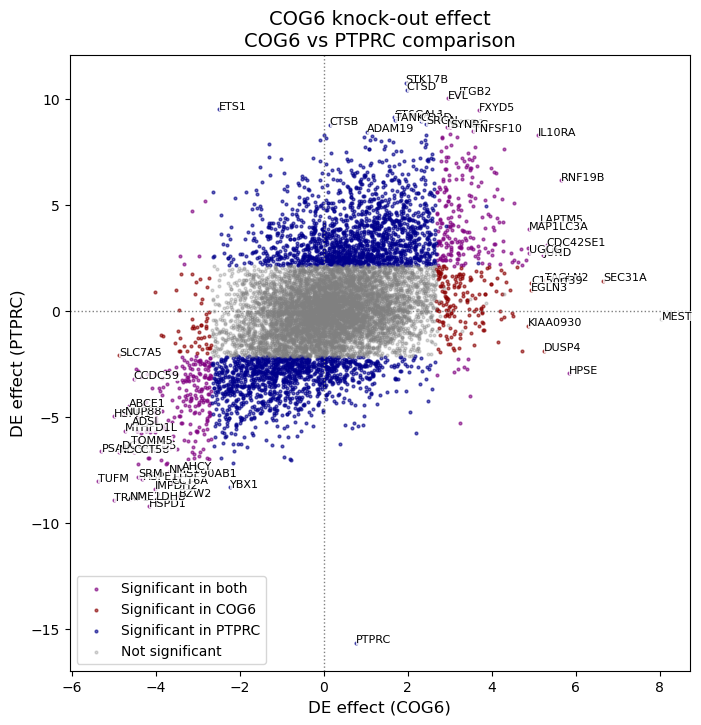

In [28]:
plot_effect_comparison(
    adata_de, 
    {'target_contrast_gene_name':['COG6', 'PTPRC'], 'stat':['zscore'], 'culture_condition':['Stim48hr']},
    annotate_significant=True
    )

In [37]:
# Get results for disease-associated genes
res_df = get_DE_results_long(
    adata_de, 
    targets=['COG6']
    )
res_df[res_df['gene'] == 'COG6']

,index,gene,log_fc,zscore,adj_p_value,significant,gene_name,culture_condition,target_contrast,target_contrast_gene_name
1812,ENSG00000133103_Rest,COG6,-1.997536,-2.487363,0.134846,False,COG6,Rest,ENSG00000133103,COG6
12094,ENSG00000133103_Stim48hr,COG6,-2.997948,-2.807496,0.080112,True,COG6,Stim48hr,ENSG00000133103,COG6
22376,ENSG00000133103_Stim8hr,COG6,-2.319549,-2.694524,0.069463,True,COG6,Stim8hr,ENSG00000133103,COG6


In [44]:
# Potential offtargets
disease_de_stats[disease_de_stats['offtarget_flag']].target_name.unique()

array(['GNGT2', 'ZFYVE26', 'CLEC16A'], dtype=object)

In [ ]:
res_df[res_df['target_contrast_gene_name'] == 'SLC27A3'].sort_values('zscore')

,index,gene,log_fc,zscore,adj_p_value,significant,gene_name,culture_condition,target_contrast,target_contrast_gene_name
879265,ENSG00000143554_Rest,ENSG00000143554,-3.282569,-6.721558,NaN,False,SLC27A3,Rest,ENSG00000143554,SLC27A3
889547,ENSG00000143554_Stim48hr,ENSG00000143554,-4.602737,-5.394675,0.000870,True,SLC27A3,Stim48hr,ENSG00000143554,SLC27A3
899829,ENSG00000143554_Stim8hr,ENSG00000143554,-2.894875,-4.070666,0.549084,False,SLC27A3,Stim8hr,ENSG00000143554,SLC27A3
881491,ENSG00000143554_Rest,ENSG00000169442,-0.333622,-4.008334,0.016074,True,CD52,Rest,ENSG00000143554,SLC27A3
877748,ENSG00000143554_Rest,ENSG00000127528,-0.352526,-4.004219,0.016074,True,KLF2,Rest,ENSG00000143554,SLC27A3
...,...,...,...,...,...,...,...,...,...,...
879505,ENSG00000143554_Rest,ENSG00000146731,0.407292,4.454827,0.006911,True,CCT6A,Rest,ENSG00000143554,SLC27A3
877252,ENSG00000143554_Rest,ENSG00000120694,0.510700,4.459149,0.006911,True,HSPH1,Rest,ENSG00000143554,SLC27A3
880228,ENSG00000143554_Rest,ENSG00000158457,2.634667,4.754408,NaN,False,TSPAN33,Rest,ENSG00000143554,SLC27A3
877118,ENSG00000143554_Rest,ENSG00000118985,1.167350,4.941725,0.002526,True,ELL2,Rest,ENSG00000143554,SLC27A3


In [194]:
disease_de_stats[disease_de_stats.target_name == 'SLC27A3']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
4971,ENSG00000143554,SLC27A3,Stim8hr,693.0,0,0,0,-4.070666,False,2.510151,False,no effect,no on-target KD
9215,ENSG00000143554,SLC27A3,Rest,682.0,143,45,188,-6.721558,False,7.077942,False,>10 DE genes,no on-target KD
19311,ENSG00000143554,SLC27A3,Stim48hr,800.0,0,1,1,-5.394675,True,5.000152,False,1 DE gene,on-target KD


### Exploratory analysis of trans-effects

In [11]:
# Sort targets by mean number of DE genes across conditions
target_order = disease_de_stats.groupby('target_name')['n_total_de_genes'].mean().sort_values().index

# Define condition order and colors
condition_order = ['Rest', 'Stim8hr', 'Stim48hr']

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 9), height_ratios=[1, 2], sharex=True)

## Top subplot: N cells barplot ##
sns.barplot(
    data=disease_de_stats,
    x='target_name', y='n_cells_target',
    order=target_order,
    color='lightgrey',
    ax=ax1
)
ax1.set_ylabel('# perturbed cells', fontsize=14)
ax1.tick_params(axis='y', labelsize=12)

## Bottom subplot: N DE genes barplot ##
sns.barplot(
    data=disease_de_stats,
    x='target_name', 
    y='n_total_de_genes',
    hue='condition',
    hue_order=condition_order,
    order=target_order,
    palette=palettes['culture_condition'],
    ax=ax2
)

# Plot points for significant targets
points_data = disease_de_stats[disease_de_stats['ontarget_significant']].copy()
points_data['n_total_de_genes'] = points_data['n_total_de_genes'] * 1.1  # Offset by 10%

sns.stripplot(
    data=points_data,
    x='target_name', 
    y='n_total_de_genes',
    hue='condition',
    dodge=True,
    hue_order=condition_order,
    order=target_order,
    color='black',
    size=3,
    jitter=True,
    zorder=10,
    legend=False,
    ax=ax2
)

ax2.set_yscale('log')
ax2.set_xlabel('Allergic Asthma GWAS genes (Open Targets)', fontsize=14)
ax2.set_ylabel('# Significant DE genes (10% FDR)', fontsize=14)
ax2.tick_params(axis='x', rotation=90, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(fontsize=12)
plt.tight_layout()


NameError: name 'disease_de_stats' is not defined

In [159]:
keep_tests = disease_de_stats[disease_de_stats['ontarget_significant'] & (disease_de_stats['n_total_de_genes'] > 2)]
keep_tests = (keep_tests['target_contrast'] + '_' + keep_tests['condition']).tolist()
res_df = res_df[res_df['index'].isin(keep_tests)]

# annotate downstream genes by cluster identity
cl_res = clust_adata.obs.rename(columns={'target_contrast_gene_name': 'gene_name'})[['gene_name', 'culture_condition', 'clustering']]
res_df = pd.merge(res_df, cl_res, on=['gene_name', 'culture_condition'])

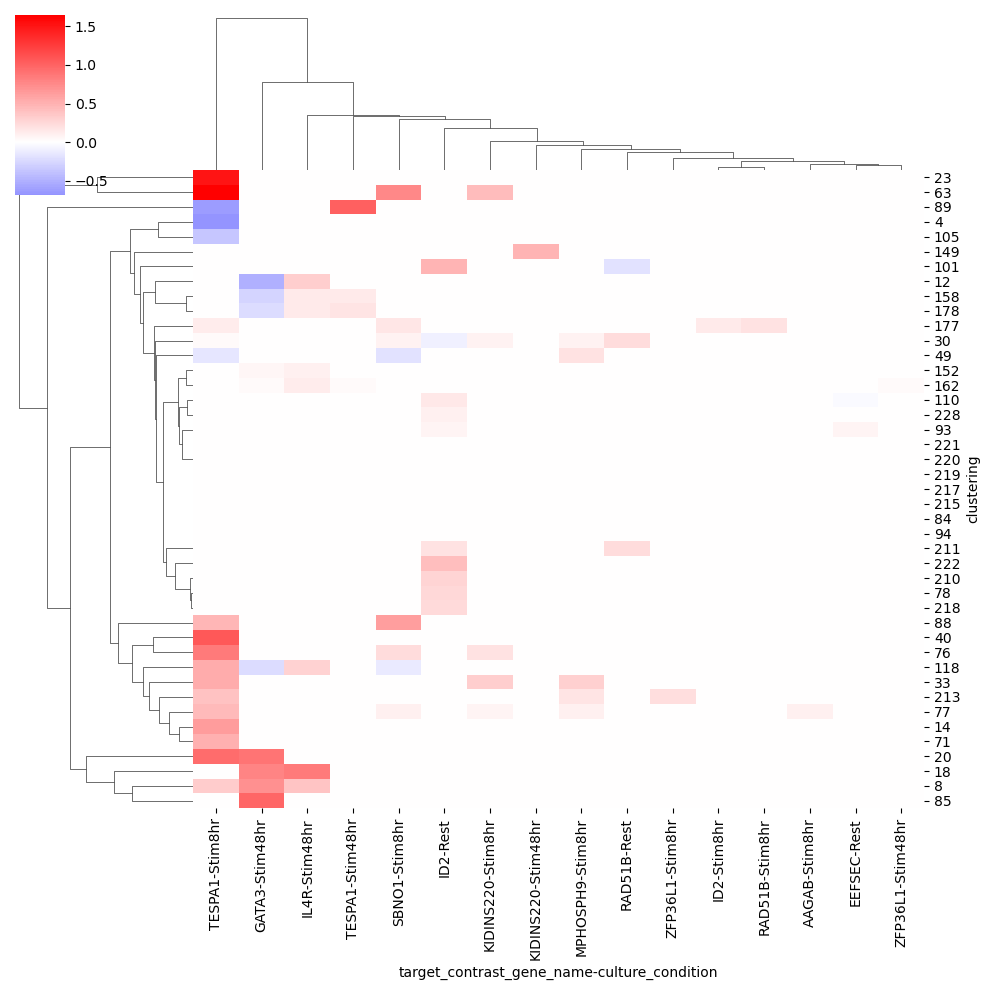

In [190]:
signif_res_df = res_df.copy()
signif_res_df['zscore'] = np.where(signif_res_df['significant'], signif_res_df['zscore'], 0)
mean_cl_effect = signif_res_df.groupby(['target_contrast_gene_name', 'culture_condition', 'clustering'])['zscore'].mean().reset_index()
mean_cl_effect = mean_cl_effect.pivot(columns=['target_contrast_gene_name', 'culture_condition'], index='clustering', values='zscore').fillna(0)

sns.clustermap(mean_cl_effect.loc[mean_cl_effect.sum(1) > 0, mean_cl_effect.sum() > 0], cmap='bwr', center=0, yticklabels=True)

In [193]:
mean_cl_effect.loc[115].sort_values()

target_contrast_gene_name  culture_condition
RAD51B                     Stim48hr            -1.992507
AAGAB                      Rest                 0.000000
                           Stim48hr             0.000000
                           Stim8hr              0.000000
ANXA2                      Stim8hr              0.000000
                                                  ...   
ZNF652                     Stim48hr             0.000000
                           Stim8hr              0.000000
                           Rest                 0.000000
GATA3                      Stim48hr             0.571622
ID2                        Stim48hr             0.576624
Name: 115, Length: 165, dtype: float64

In [188]:
mean_cl_effect['GATA3']['Stim48hr'].sort_values()

clustering
132   -1.462810
131   -0.628200
12    -0.508602
19    -0.479836
190   -0.464588
         ...   
18     0.791351
21     0.891660
20     0.897329
85     0.976902
42     1.115383
Name: Stim48hr, Length: 96, dtype: float64

In [ ]:
res_df['index'].isin

,index,gene,log_fc,zscore,adj_p_value,significant,gene_name,culture_condition,target_contrast,target_contrast_gene_name
41128,ENSG00000038532_Stim48hr,ENSG00000000419,-0.001589,-0.032322,0.999999,False,DPM1,Stim48hr,ENSG00000038532,CLEC16A
41129,ENSG00000038532_Stim48hr,ENSG00000000457,0.119857,1.168007,0.999999,False,SCYL3,Stim48hr,ENSG00000038532,CLEC16A
41130,ENSG00000038532_Stim48hr,ENSG00000000460,-0.000244,-0.003516,0.999999,False,C1orf112,Stim48hr,ENSG00000038532,CLEC16A
41131,ENSG00000038532_Stim48hr,ENSG00000000971,-0.217576,-0.301009,0.999999,False,CFH,Stim48hr,ENSG00000038532,CLEC16A
41132,ENSG00000038532_Stim48hr,ENSG00000001036,0.052687,0.386234,0.999999,False,FUCA2,Stim48hr,ENSG00000038532,CLEC16A
...,...,...,...,...,...,...,...,...,...,...
1542295,ENSG00000203896_Rest,ENSG00000284770,-0.126174,-1.048496,0.999961,False,TBCE,Rest,ENSG00000203896,LIME1
1542296,ENSG00000203896_Rest,ENSG00000285077,-0.251159,-1.667771,0.999961,False,ARHGAP11B,Rest,ENSG00000203896,LIME1
1542297,ENSG00000203896_Rest,ENSG00000288722,0.022267,0.035607,0.999961,False,F8A1,Rest,ENSG00000203896,LIME1
1542298,ENSG00000203896_Rest,ENSG00000290292,0.102108,0.640432,0.999961,False,HOMEZ,Rest,ENSG00000203896,LIME1


,index,gene,log_fc,zscore,adj_p_value,significant,gene_name,culture_condition,target_contrast,target_contrast_gene_name,pl_index
0,ENSG00000006062_Rest,ENSG00000000419,-0.007844,-0.086414,0.999957,False,DPM1,Rest,ENSG00000006062,MAP3K14,MAP3K14 - Rest
1,ENSG00000006062_Rest,ENSG00000000457,0.012819,0.087092,0.999957,False,SCYL3,Rest,ENSG00000006062,MAP3K14,MAP3K14 - Rest
2,ENSG00000006062_Rest,ENSG00000000460,-0.270816,-1.694006,0.734372,False,C1orf112,Rest,ENSG00000006062,MAP3K14,MAP3K14 - Rest
3,ENSG00000006062_Rest,ENSG00000000971,-0.674533,-0.601345,0.999957,False,CFH,Rest,ENSG00000006062,MAP3K14,MAP3K14 - Rest
4,ENSG00000006062_Rest,ENSG00000001036,-0.173998,-0.719831,0.999957,False,FUCA2,Rest,ENSG00000006062,MAP3K14,MAP3K14 - Rest
...,...,...,...,...,...,...,...,...,...,...,...
1645115,ENSG00000258366_Stim8hr,ENSG00000284770,0.120168,0.272233,NaN,False,TBCE,Stim8hr,ENSG00000258366,RTEL1,RTEL1 - Stim8hr
1645116,ENSG00000258366_Stim8hr,ENSG00000285077,-0.606409,-0.999900,NaN,False,ARHGAP11B,Stim8hr,ENSG00000258366,RTEL1,RTEL1 - Stim8hr
1645117,ENSG00000258366_Stim8hr,ENSG00000288722,0.563336,0.436694,NaN,False,F8A1,Stim8hr,ENSG00000258366,RTEL1,RTEL1 - Stim8hr
1645118,ENSG00000258366_Stim8hr,ENSG00000290292,0.134520,0.205912,NaN,False,HOMEZ,Stim8hr,ENSG00000258366,RTEL1,RTEL1 - Stim8hr


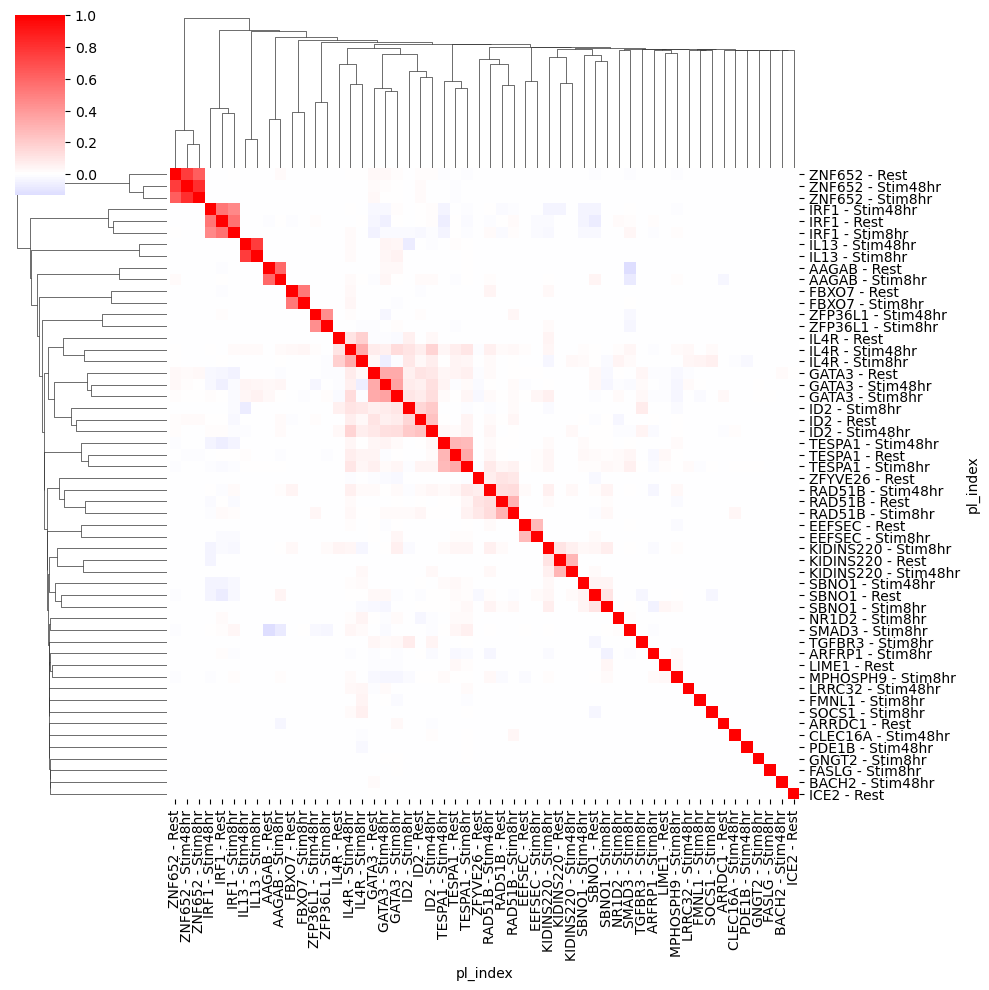

In [69]:
wide_zscores = res_df[res_df['index'].isin(keep_tests)].pivot(index='gene_name', columns=['pl_index'], values='zscore')
wide_padj = res_df[res_df['index'].isin(keep_tests)].pivot(index='gene_name', columns=['pl_index'], values='adj_p_value')
signif_mask = wide_padj < 0.1

cormat = wide_zscores[signif_mask].fillna(0).corr()
sns.clustermap(cormat, cmap='bwr', center=0, xticklabels=True, yticklabels=True)

In [132]:
# Get results for disease-associated genes
res_df = get_DE_results_long(
    adata_de, 
    targets=['SLC5A6', 'RAD54L2', 'FHL1', 'UBXN1', 'CCDC12', 'CLCC1', 'ITM2A', 'MAX', 'EFHD2', 'GALK2', 'ENDOG', 'HIST1H2BI', 'TIMM10', 'PARP14', 'DRAP1', 'KRBA2', 'STOM', 'NCAPG2', 'ATF7IP2', 'PAK1', 'MMP9', 'AP1S2', 'TENT2', 'ZNF154', 'ULK4', 'ATL1', 'RWDD2B', 'DIS3L2', 'SAC3D1', 'FAM229A', 'CRTAP', 'HLA-DOA', 'IFFO2', 'WDR54', 'SLC25A27', 'SLC17A5', 'CXorf40A', 'ZMAT1', 'FBXL15', 'EDC3', 'PCBP2', 'ZNF93', 'TIA1', 'DEFA6', 'GPR15', 'EIF1AX', 'ATP5MC1', 'PPDPF', 'NFKBIL1', 'ANKAR', 'PRAM1', 'RHOF', 'BCL11B', 'SPSB2', 'TESPA1', 'ZNF177', 'DET1', 'LRP2BP', 'HSDL2', 'NPHP4', 'SPTBN1', 'KRCC1', 'SIK2', 'MAP3K1', 'CRYZL1', 'ATG12', 'DNAH3', 'RPP25L', 'DCAKD', 'EGR3', 'NDUFS8', 'FBXL3', 'KPNA1', 'GZMB', 'CCDC138', 'MTMR3', 'THAP11', 'SCRN3']
    )

In [133]:
act = pd.read_csv('../4_polarization_signatures/Arce2024_20230130_DESeq2_output_AAVS1_Teff_Stimulation_vs_Resting.csv')
up_activation = act[(act['padj'] < 0.01) & (act.log2FoldChange > 4)].gene_name.tolist()
down_activation = act[(act['padj'] < 0.01) & (act.log2FoldChange < 4)].gene_name.tolist()
len(up_activation)


158

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


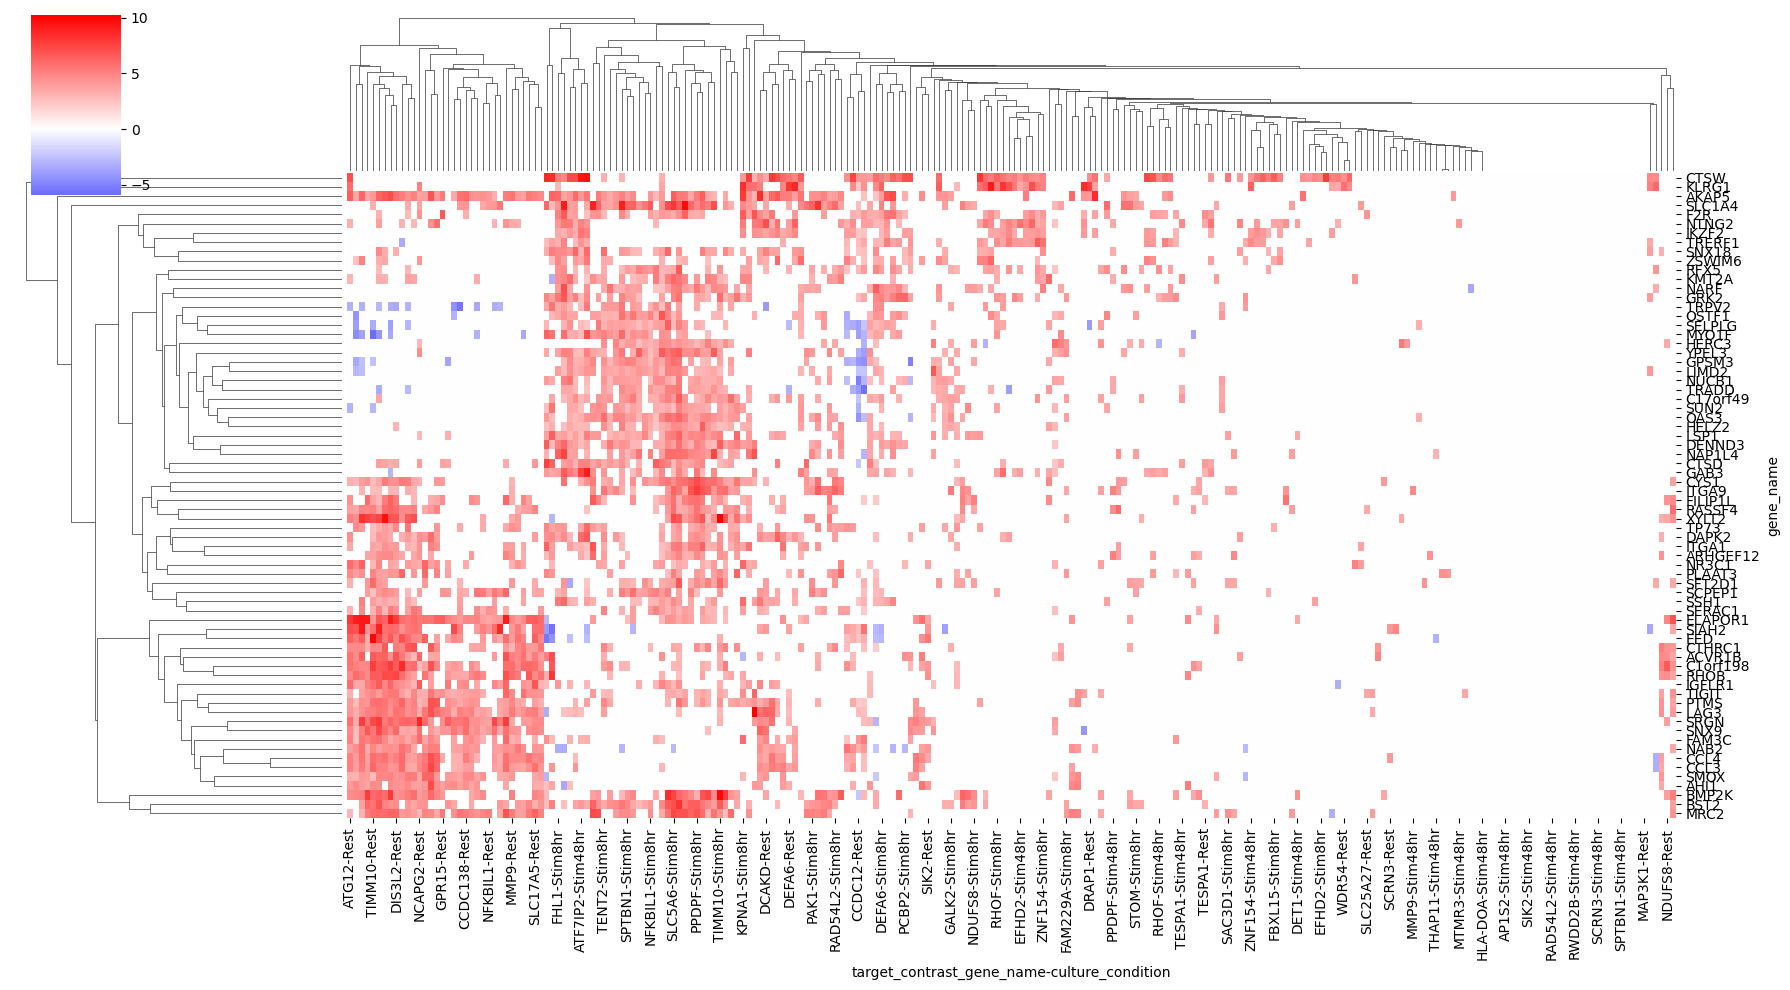

In [140]:
show_gs = res_df[res_df['significant']].pivot(index='gene_name', columns=['target_contrast_gene_name', 'culture_condition'], values='significant').fillna(0).sum(1).sort_values(ascending=False)[0:70].index
sns.clustermap(res_df[res_df['significant']].pivot(index='gene_name', columns=['target_contrast_gene_name', 'culture_condition'], values='zscore').fillna(0).loc[show_gs], cmap='bwr', center=0, figsize=(18,10), yticklabels=True)

In [139]:
# Create contingency table for Fisher's exact test
show_gs_set = set(show_gs)
up_activation_set = set(up_activation + down_activation)

# Count overlaps
in_both = len(show_gs_set & up_activation_set)
only_show_gs = len(show_gs_set - up_activation_set) 
only_up_activation = len(up_activation_set - show_gs_set)
in_neither = len(set(res_df.gene_name.unique()) - show_gs_set - up_activation_set)

contingency = [[in_both, only_show_gs],
               [only_up_activation, in_neither]]

# Run Fisher's exact test
odds_ratio, pvalue = scipy.stats.fisher_exact(contingency)

print(f"Fisher's exact test results:")
print(f"Odds ratio: {odds_ratio:.2f}")
print(f"P-value: {pvalue:.2e}")
print(f"\nOverlapping genes:")
print(sorted(list(show_gs_set & up_activation_set)))

Fisher's exact test results:
Odds ratio: 0.98
P-value: 1.00e+00

Overlapping genes:
['BST2', 'CCL3', 'CCL4', 'CTSD', 'FAM3C', 'GAB3', 'IKZF2', 'ITGA1', 'KMT2A', 'LAG3', 'NAB2', 'NARF', 'OAS3', 'PTMS', 'RHOB', 'SELPLG', 'SFT2D1', 'SIAH2', 'SLC1A4', 'SNX18', 'SRGN', 'SSH1', 'YPEL3']


In [47]:
res_df['pl_index'] = res_df['target_contrast_gene_name'].astype(str) + ' - ' + res_df['culture_condition'].astype(str)
# cor_res_df = res_df[res_df.adj_p_value < 0.1]
corrmat = cor_res_df[cor_res_df['index'].isin(keep_tests)].pivot(columns=['pl_index'], values='zscore', index='gene').fillna(0).corr()

NameError: name 'cor_res_df' is not defined

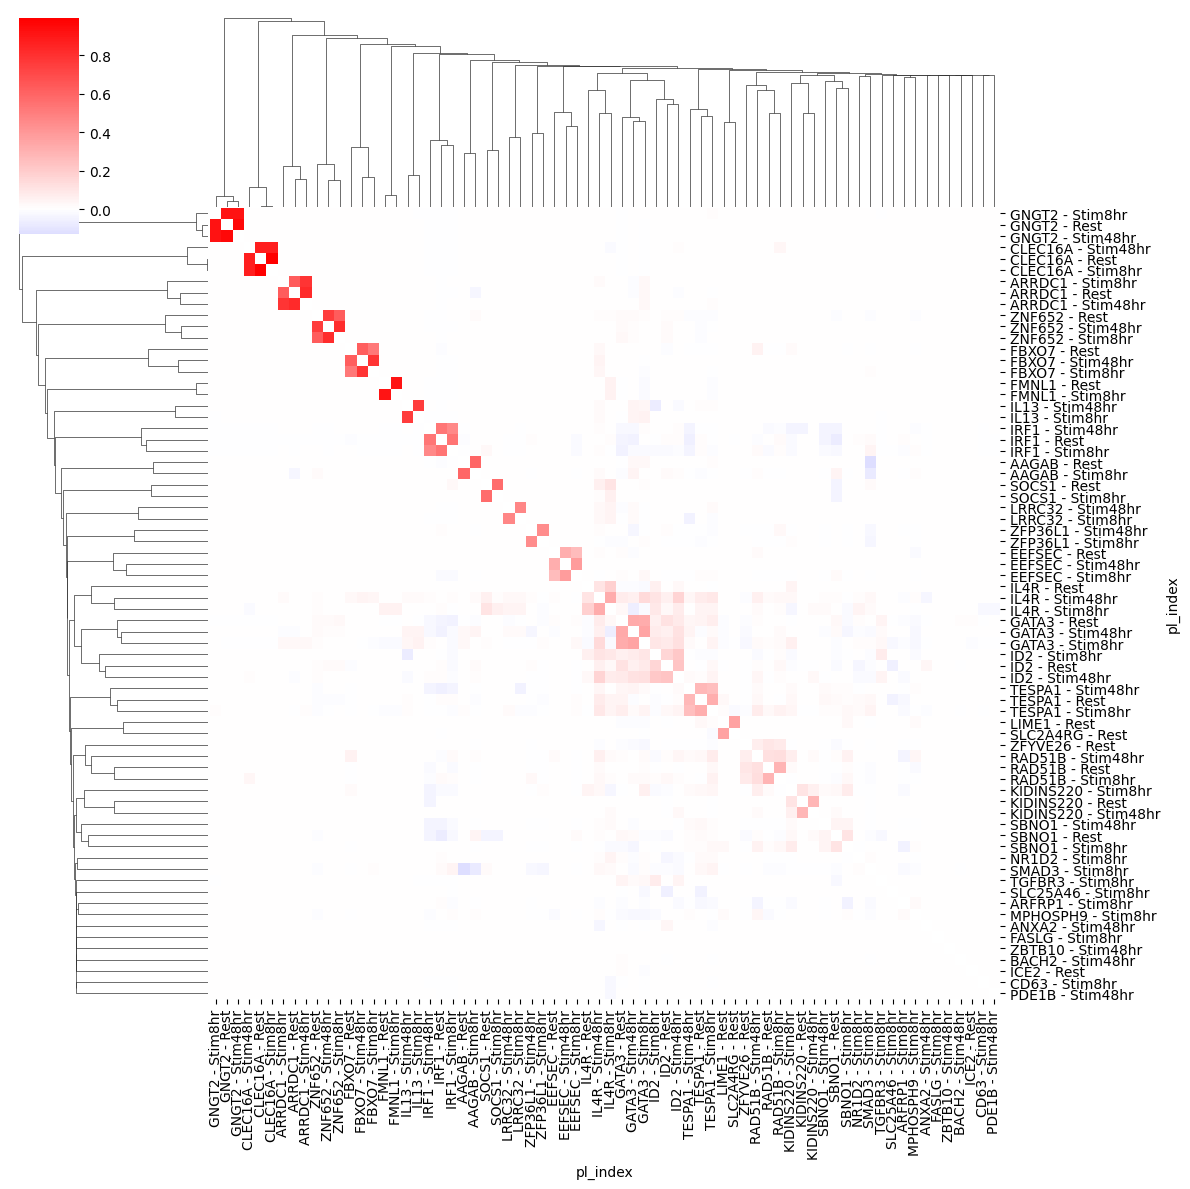

In [83]:
# Mask diagonal of correlation matrix
mask = np.eye(corrmat.shape[0], dtype=bool) #| (np.abs(corrmat) < 0.05)
sns.clustermap(corrmat, cmap='bwr', center=0, xticklabels=True, yticklabels=True, mask=mask, figsize=(12,12))

Observations
- LRRC32 has very distinct effect between Stim8hr and Stim48hr
- Main cluster 1: ARRDC1, ZNF652 and GNGT2
- Main cluster 2: IL4R, ID2, TESPA1, RAD51B, KIDINS220
- KIDINS220 has distinct effect at Stim48, but also very few cells per perturbation - KIDINS220 is also a hit in Schmidt et al

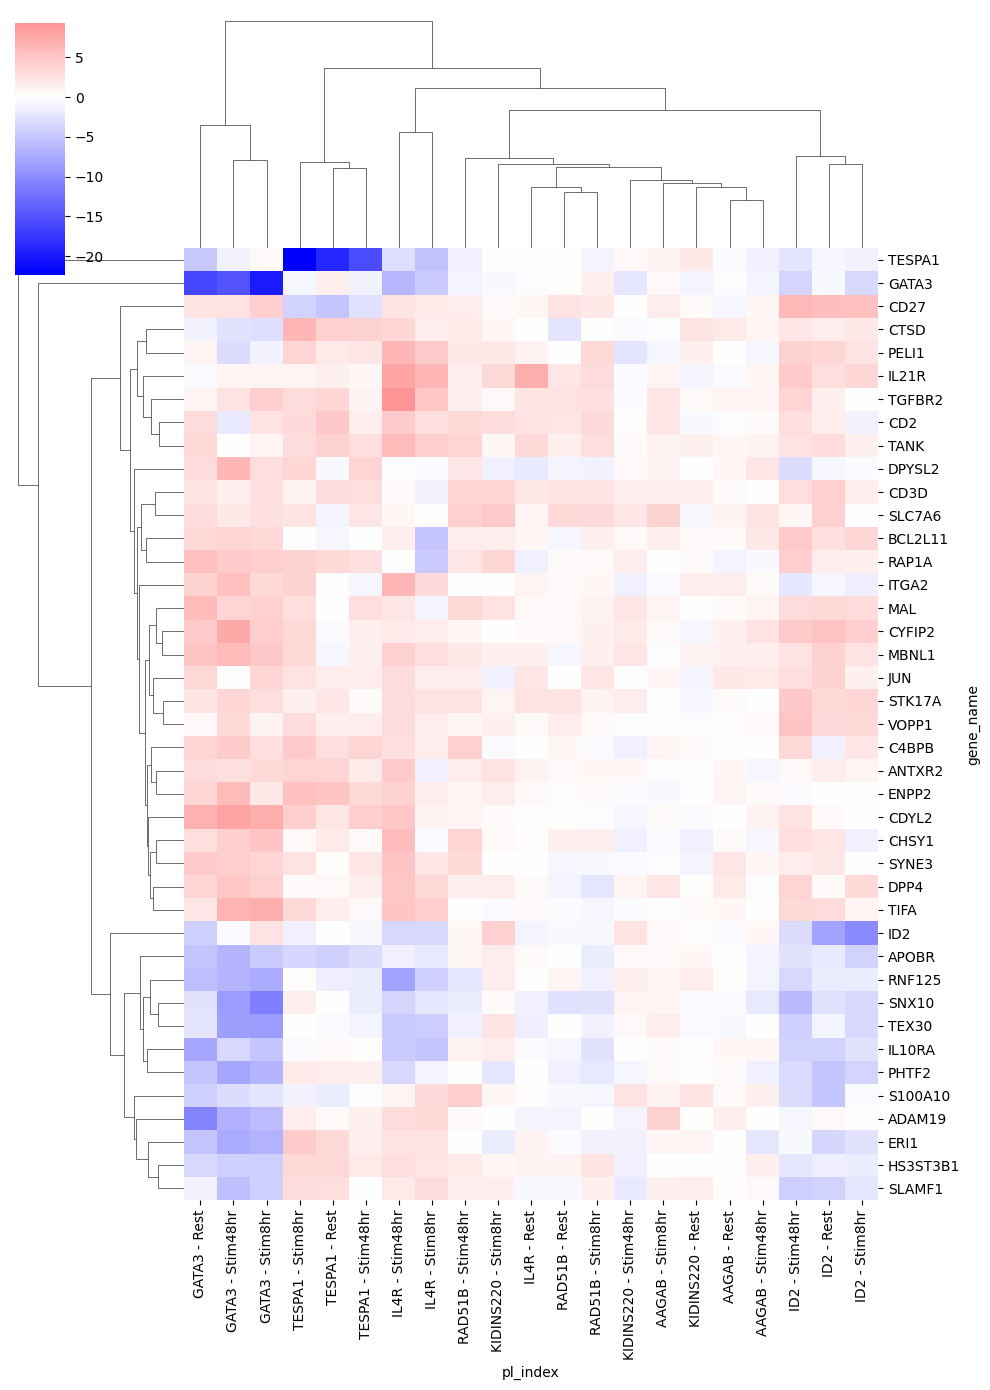

In [74]:
ts = ['IL4R', 'ID2', 'TESPA1', 'RAD51B', 'KIDINS220', 'GATA3', 'AAGAB']
pl_res_df = res_df[res_df['target_contrast_gene_name'].isin(ts)]

# Keep genes w significant effects across ts
n_signif = pl_res_df.groupby('gene_name')['significant'].sum()
pl_genes = n_signif[n_signif > 5].index.tolist()

pl_df = pl_res_df[pl_res_df.gene_name.isin(pl_genes)].pivot(index='gene_name', columns='pl_index', values='zscore')
sns.clustermap(pl_df.fillna(0), cmap='bwr', center=0, figsize=(10,14), yticklabels=True)

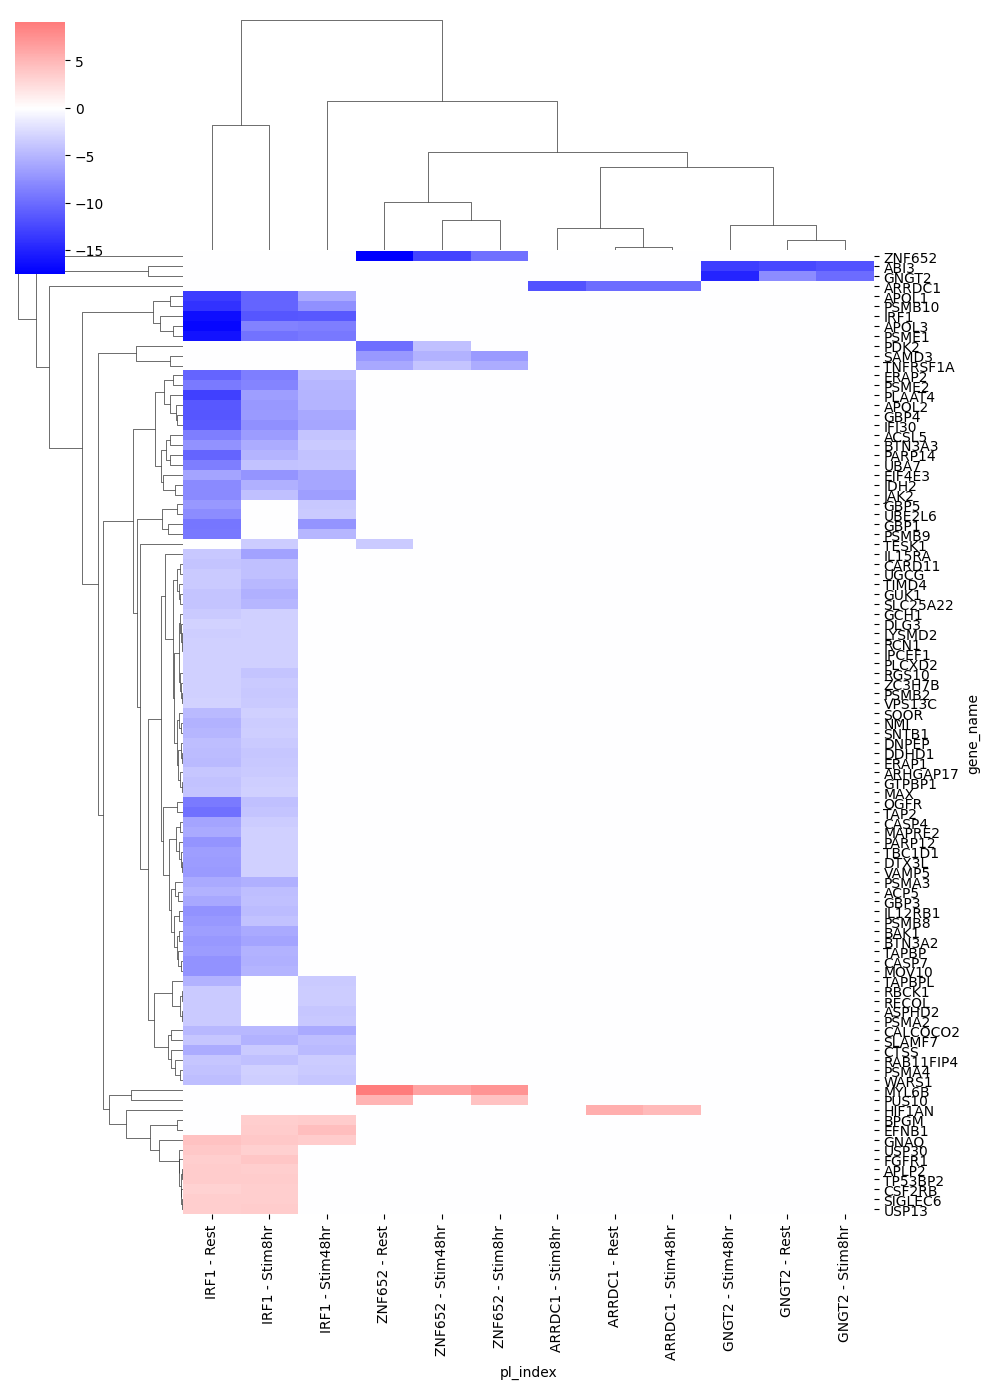

In [80]:
ts = ['ARRDC1', 'ZNF652','GNGT2', 'IRF1']
pl_res_df = res_df[res_df['target_contrast_gene_name'].isin(ts)]

# Keep genes w significant effects across ts
n_signif = pl_res_df.groupby('gene_name')['significant'].sum()
pl_genes = n_signif[n_signif > 1].index.tolist()

pl_df = pl_res_df[pl_res_df.gene_name.isin(pl_genes) & (pl_res_df['adj_p_value'] < 0.1)].pivot(index='gene_name', columns='pl_index', values='zscore')

sns.clustermap(pl_df.fillna(0), cmap='bwr', center=0, figsize=(10,14), yticklabels=True)

In [117]:
# # Read functional interaction clusters
# funcint_clusters = pd.read_csv(f"../../metadata/rest_functional_group.csv", index_col=0)
# funcint_clusters['is_disease_gene'] = funcint_clusters['gene'].isin(disease_genes.gene_symbol)
# disease_cl = funcint_clusters[funcint_clusters['gene'].isin(disease_genes.gene_symbol)]['functional_group'].unique()

# funcint_clusters = funcint_clusters[funcint_clusters['functional_group'].isin(disease_cl)].sort_values('functional_group')

# for g in funcint_clusters.functional_group.unique():

#     print(funcint_clusters[funcint_clusters.functional_group == g].sort_values('is_disease_gene', ascending=False))
#     print(funcint_clusters[funcint_clusters.functional_group == g].sort_values('is_disease_gene', ascending=False).gene.tolist())

          gene  functional_group  is_disease_gene
811     RAD51B                 3             True
986      FANCE                 3            False
1294     ATAD5                 3            False
459      FANCF                 3            False
1330     GNB1L                 3            False
788      FNBP4                 3            False
1003       ICK                 3            False
1147      RNF8                 3            False
1035    FANCD2                 3            False
31       DDX17                 3            False
1079      GID8                 3            False
29      TCEAL1                 3            False
977      CEP89                 3            False
610      FANCL                 3            False
915     CHTF18                 3            False
936       UBA2                 3            False
853      TNNC1                 3            False
861       REST                 3            False
1518     NR2C2                 3            False


In [126]:
g = 35
res_df = get_DE_results_long(
    adata_de, 
    targets=funcint_clusters[funcint_clusters.functional_group == g].sort_values('is_disease_gene', ascending=False).gene.tolist()
    )
res_df = res_df[res_df['culture_condition'] =='Rest']
res_df

,index,gene,log_fc,zscore,adj_p_value,significant,gene_name,culture_condition,target_contrast,target_contrast_gene_name
0,ENSG00000003393_Rest,ENSG00000000003,0.017845,0.000586,NaN,False,TSPAN6,Rest,ENSG00000003393,ALS2
1,ENSG00000003393_Rest,ENSG00000000419,-0.131906,-1.570560,0.465387,False,DPM1,Rest,ENSG00000003393,ALS2
2,ENSG00000003393_Rest,ENSG00000000457,0.101810,0.741487,0.799150,False,SCYL3,Rest,ENSG00000003393,ALS2
3,ENSG00000003393_Rest,ENSG00000000460,-0.265314,-1.935734,0.347850,False,C1orf112,Rest,ENSG00000003393,ALS2
4,ENSG00000003393_Rest,ENSG00000000938,-0.072783,-0.037241,NaN,False,FGR,Rest,ENSG00000003393,ALS2
...,...,...,...,...,...,...,...,...,...,...
963166,ENSG00000196535_Rest,ENSG00000290292,0.095057,0.545933,0.999951,False,HOMEZ,Rest,ENSG00000196535,TIAF1
963167,ENSG00000196535_Rest,ENSG00000290795,NaN,NaN,NaN,False,C2orf83,Rest,ENSG00000196535,TIAF1
963168,ENSG00000196535_Rest,ENSG00000290797,-0.564783,-1.018689,0.999951,False,ENSG00000290797,Rest,ENSG00000196535,TIAF1
963169,ENSG00000196535_Rest,ENSG00000291096,NaN,NaN,NaN,False,ENSG00000291096,Rest,ENSG00000196535,TIAF1


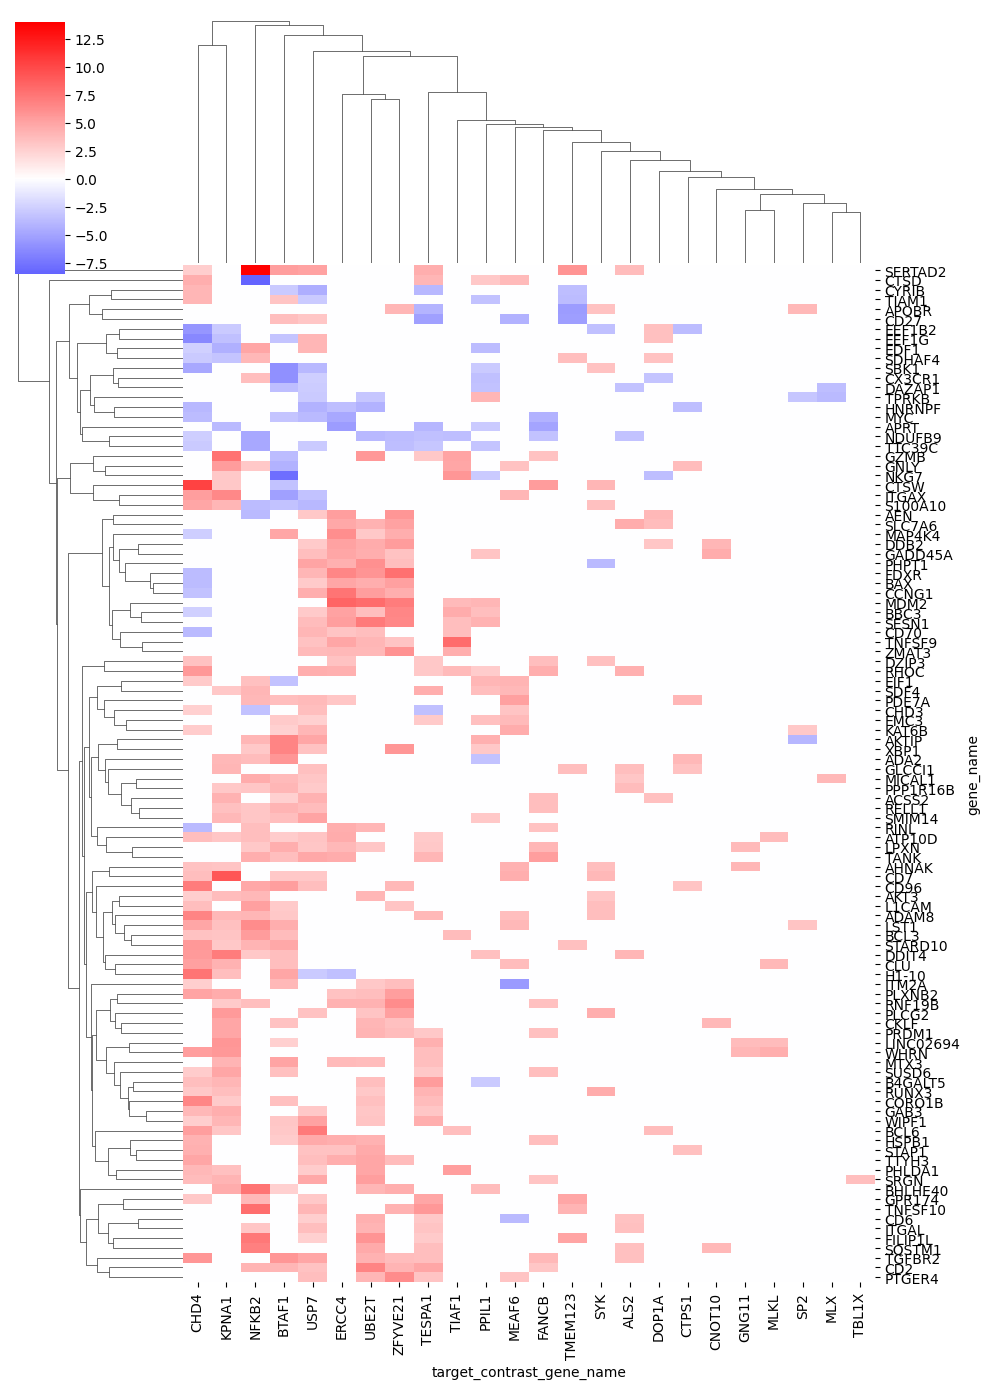

In [130]:
pl_df = res_df[res_df['adj_p_value'] < 0.1].pivot(index='gene_name', columns='target_contrast_gene_name', values='zscore')
# Keep only rows with at least 10 non-NA values
pl_df = pl_df[pl_df.notna().sum(axis=1) >= 5]

sns.clustermap(pl_df.fillna(0), cmap='bwr', center=0, figsize=(10,14), yticklabels=True)

In [7]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
funcint_clusters = pd.read_csv(f"{datadir}/DE_results_all_confounders/pymde_results.csv")
funcint_clusters['gene'] = funcint_clusters['culture_condition'].str.split("_").str[1]
funcint_clusters.head()

,culture_condition,pyMDE_1,pyMDE_2,cluster,timepoint,gene
0,Stim8hr_PLAT,-3.483215,-3.957370,153,Stim8hr,PLAT
1,Stim8hr_HSPA8,1.376025,-0.018327,223,Stim8hr,HSPA8
2,Stim8hr_KLHDC10,-3.510246,1.283592,223,Stim8hr,KLHDC10
3,Stim8hr_ICOS,-3.050679,-0.345425,142,Stim8hr,ICOS
4,Stim8hr_ANKRD49,-0.335842,-0.523981,20,Stim8hr,ANKRD49


In [23]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

/tmp/ipykernel_709779/3207750399.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disease_clusters_genes['is_disease_gene'] = disease_clusters_genes.gene.isin(disease_genes.gene_symbol)


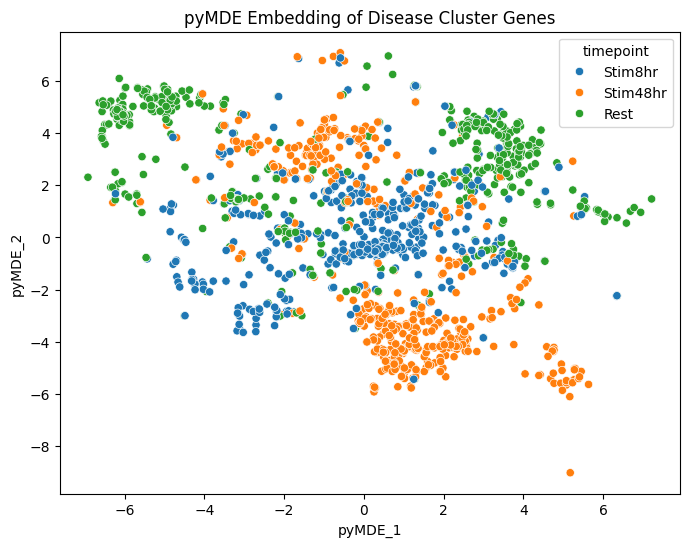

In [16]:
# First get clusters containing disease genes
disease_genes_cl = funcint_clusters[funcint_clusters.gene.isin(disease_genes.gene_symbol)].cluster.unique()
# Then get all genes in those clusters
disease_clusters_genes = funcint_clusters[funcint_clusters.cluster.isin(disease_genes_cl)]
disease_clusters_genes['is_disease_gene'] = disease_clusters_genes.gene.isin(disease_genes.gene_symbol)
disease_clusters_genes

plt.figure(figsize=(8,6))
sns.scatterplot(data=disease_clusters_genes, x='pyMDE_1', y='pyMDE_2', hue='timepoint')
plt.title('pyMDE Embedding of Disease Cluster Genes')
plt.show()

In [39]:
disease_clusters_genes[disease_clusters_genes.is_disease_gene].sort_values('cluster')

,culture_condition,pyMDE_1,pyMDE_2,cluster,timepoint,gene,is_disease_gene
2429,Rest_RAD51B,2.486664,4.320984,13,Rest,RAD51B,True
2015,Stim8hr_RAD51B,0.216638,-0.601909,23,Stim8hr,RAD51B,True
2132,Stim48hr_ID2,-0.470537,1.327854,32,Stim48hr,ID2,True
613,Rest_ID2,-0.442351,1.345668,32,Rest,ID2,True
2499,Stim8hr_ID2,-0.319029,1.325843,32,Stim8hr,ID2,True
2309,Stim48hr_ICE2,0.934996,-4.253639,37,Stim48hr,ICE2,True
1827,Rest_IRF1,-0.924502,1.754710,38,Rest,IRF1,True
187,Stim8hr_IRF1,-0.953222,1.758082,38,Stim8hr,IRF1,True
2772,Stim48hr_IRF1,-0.911272,1.777803,38,Stim48hr,IRF1,True
3485,Stim48hr_IL4R,2.299574,-4.186125,41,Stim48hr,IL4R,True


In [ ]:
# Perform cluster enrichment analysis for asthma genes
def calculate_cluster_enrichment(clustering_df, asthma_genes, gene_col, cluster_col='cluster'):
    """Calculate enrichment of asthma genes in each cluster"""
    enrichment_results = []
    
    # Get unique genes and clusters
    all_genes = set(clustering_df[gene_col].dropna())
    asthma_genes_in_data = asthma_genes & all_genes
    
    print(f"Total genes in clustering data: {len(all_genes)}")
    print(f"Asthma genes found in clustering data: {len(asthma_genes_in_data)}")
    print(f"Missing asthma genes: {len(asthma_genes - all_genes)}")
    
    for cluster_id in clustering_df[cluster_col].unique():
        if pd.isna(cluster_id):
            continue
            
        # Genes in this cluster
        cluster_genes = set(clustering_df[clustering_df[cluster_col] == cluster_id][gene_col].dropna())
        
        # Create 2x2 contingency table
        asthma_in_cluster = len(cluster_genes & asthma_genes_in_data)
        asthma_not_in_cluster = len(asthma_genes_in_data - cluster_genes) 
        not_asthma_in_cluster = len(cluster_genes - asthma_genes_in_data)
        not_asthma_not_in_cluster = len(all_genes - cluster_genes - asthma_genes_in_data)
        
        # Only test if we have some asthma genes in cluster
        if asthma_in_cluster > 0:
            # Fisher's exact test
            try:
                oddsratio, pvalue = fisher_exact([[asthma_in_cluster, asthma_not_in_cluster], 
                                                 [not_asthma_in_cluster, not_asthma_not_in_cluster]])
                
                enrichment_results.append({
                    'cluster': cluster_id,
                    'asthma_genes_in_cluster': asthma_in_cluster,
                    'total_genes_in_cluster': len(cluster_genes),
                    'asthma_genes_in_data': len(asthma_genes_in_data),
                    'total_genes_in_data': len(all_genes),
                    'odds_ratio': oddsratio,
                    'p_value': pvalue,
                    'asthma_fraction': asthma_in_cluster / len(cluster_genes) if len(cluster_genes) > 0 else 0,
                    'expected_asthma': len(cluster_genes) * len(asthma_genes_in_data) / len(all_genes),
                    'fold_enrichment': (asthma_in_cluster / len(cluster_genes)) / (len(asthma_genes_in_data) / len(all_genes))
                })
            except:
                continue
    
    return pd.DataFrame(enrichment_results)

# Check if we have the necessary columns and run analysis
if 'gene_col' in locals() and 'cluster' in clustering_data.columns:
    enrichment_df = calculate_cluster_enrichment(clustering_data, asthma_genes, gene_col, 'cluster')
    
    if len(enrichment_df) > 0:
        # Apply multiple testing correction
        from statsmodels.stats.multitest import multipletests
        _, enrichment_df['p_adjusted'], _, _ = multipletests(enrichment_df['p_value'], method='fdr_bh')
        
        # Sort by p-value and show significant results
        enrichment_df_sorted = enrichment_df.sort_values('p_value')
        print(f"\nCluster enrichment results (top 10):")
        print(enrichment_df_sorted[['cluster', 'asthma_genes_in_cluster', 'total_genes_in_cluster', 'fold_enrichment', 'p_value', 'p_adjusted']].head(10))
        
        # Show clusters with significant enrichment
        significant_clusters = enrichment_df_sorted[enrichment_df_sorted['p_adjusted'] < 0.05]
        print(f"\nSignificantly enriched clusters (FDR < 0.05): {len(significant_clusters)}")
        if len(significant_clusters) > 0:
            print(significant_clusters[['cluster', 'asthma_genes_in_cluster', 'total_genes_in_cluster', 'fold_enrichment', 'p_adjusted']])
    else:
        print("No enrichment results found - check gene column identification")

In [91]:
res_df = get_DE_results_long(
    adata_de, 
    targets=disease_genes.gene_symbol
    )
res_df = res_df[res_df['culture_condition'] =='Rest']
res_df[res_df['target_contrast_gene_name'] == 'SLC27A3'].sort_values('adj_p_value').head()

,index,gene,log_fc,zscore,adj_p_value,significant,gene_name,culture_condition,target_contrast,target_contrast_gene_name
1190526,ENSG00000143554_Rest,ENSG00000118985,1.167350,4.941725,0.002526,True,ELL2,Rest,ENSG00000143554,SLC27A3
1190704,ENSG00000143554_Rest,ENSG00000120694,0.510700,4.459149,0.006911,True,HSPH1,Rest,ENSG00000143554,SLC27A3
1199337,ENSG00000143554_Rest,ENSG00000198805,0.282103,4.452846,0.006911,True,PNP,Rest,ENSG00000143554,SLC27A3
1193668,ENSG00000143554_Rest,ENSG00000146731,0.407292,4.454827,0.006911,True,CCT6A,Rest,ENSG00000143554,SLC27A3
1194369,ENSG00000143554_Rest,ENSG00000155115,0.223942,4.037344,0.016074,True,GTF3C6,Rest,ENSG00000143554,SLC27A3


In [86]:

# .loc[disease_clusters_genes.culture_condition]

,index,gene,log_fc,zscore,adj_p_value,significant,gene_name,culture_condition,target_contrast,target_contrast_gene_name
